In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision import datasets, transforms, models
import numpy as np
import random
import matplotlib.pyplot as plt
from resnet import resnet32

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
cifar10_train = datasets.CIFAR10('~/train', download=True, train=True, transform=transform_train)
cifar10_test = datasets.CIFAR10('~/test',download=True, train=False, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# get comfortable with dimensions and types
print(cifar10_train.data.shape)
print(type(cifar10_train.data))
print(cifar10_train.targets.count(1)) # list has no attribute shape
print(type(cifar10_train.targets))
print(cifar10_train.data[0].shape)

(50000, 32, 32, 3)
<class 'numpy.ndarray'>
5000
<class 'list'>
(32, 32, 3)


In [4]:
num_classes = float(len(cifar10_train.classes))
imbalance_ratio = 100.0
imbalance_factor = math.exp(-math.log(imbalance_ratio)/(num_classes-1))
print(imbalance_factor)

0.599484250318941


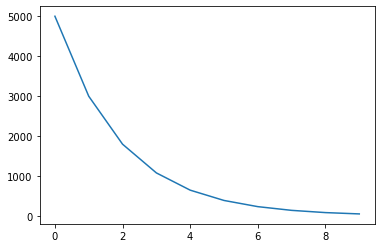

In [5]:
y = []
for i in range(10):
  num_samples_i = int(5000 * (imbalance_factor)**(i))
  y.append(num_samples_i)

fig, ax = plt.subplots()  
ax.plot(range(10), y);  # confirms that long-tailed setting is achieved
  

In [6]:
num_samples_0 = cifar10_train.targets.count(0)
all_indexes_seperate = []
pi_list = []
for i in range(10): # 10 classes
  num_samples_i = int(num_samples_0 * (imbalance_factor)**(i))
  i_indexes = [k for k, j in enumerate(cifar10_train.targets) if j == i]
  sample_indexes = random.sample(i_indexes, num_samples_i)
  all_indexes_seperate.append(sample_indexes)
  pi_list.append(len(sample_indexes))
  # sampled_images = cifar10_train.data[sample_indexes]
  # print(sampled_images.shape)

all_indexes = sum(all_indexes_seperate, []) # collapse list
sampled_images = cifar10_train.data[all_indexes] 
sampled_targets = np.array(cifar10_train.targets)[all_indexes]
pi_list_tensor = torch.tensor(pi_list) / len(all_indexes)
log_prob_tensor = torch.log(pi_list_tensor)
cifar10_train.data = sampled_images
cifar10_train.targets = list(sampled_targets)

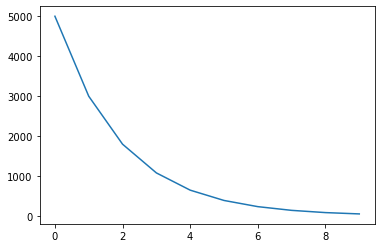

In [7]:
y = []
for i in range(10):
  num_samples_i = int(cifar10_train.targets.count(0) * (imbalance_factor)**(i))
  y.append(num_samples_i)

fig, ax = plt.subplots()  
ax.plot(range(10), y);  # confirms that long-tailed setting is achieved

In [8]:
trainloader = torch.utils.data.DataLoader(cifar10_train, batch_size=16, shuffle=True)
testloader =  torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=True)
model = resnet32()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [160, 180], gamma = 0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
num_epochs = 200
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        model.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()    
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

RuntimeError: Expected object of scalar type Long but got scalar type Int for argument #2 'target' in call to _thnn_nll_loss_forward

In [ ]:
correct = 0
total = 0
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    model.to(device)
    with torch.no_grad():
      outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    torch.cuda.empty_cache()

print('Accuracy: {} %'.format(100 * correct / total))

In [ ]:
def test_posthoc(testloader, temp, log_prob):
  correct = 0
  total = 0
  for images, labels in testloader:
      images = images.to(device)
      labels = labels.to(device)
      # model.to(device)
      with torch.no_grad():
        outputs = model(images)
      logits = outputs.data - (temp * log_prob).to(device) 
      _, predicted = torch.max(logits, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      torch.cuda.empty_cache()

  print('Accuracy: {} %'.format(100 * correct / total))

In [ ]:
temp = 1.5
test_posthoc(testloader, temp, log_prob_tensor)

In [ ]:
class logit_adjusted_CE(nn.Module):
  def __init__(self):
    super(logit_adjusted_CE, self).__init__()
  def forward(self, preds, target, log_prob, temp):
      num = torch.exp(preds.data[target] - temp * log_prob[target])
      den = torch.exp(preds.data + (temp * log_prob).to(device))

      return -torch.log(num/torch.sum(den))



In [ ]:
# adjusted CE loss
CE_adj_loss = nn.CrossEntropyLoss((math.exp(temp)*pi_list_tensor).to(device))
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        model.to(device)
        # Forward pass
        outputs = model(images)
        loss = CE_adj_loss(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # scheduler.step()    
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [2]:
torch.__version__

'1.11.0+cpu'